## **Model 11: Medium CNN (Model 5) with LeakyReLU + Adam and only vary the batch size**

**Preprocessing from model 2**

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

IMG_SIZE = (128, 128)
SEED = 42
train_dir = "datasets/Training"
test_dir  = "datasets/Testing"

# Function to create datasets with specified batch size
def load_datasets(batch_size):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir, labels="inferred", label_mode="int",
        image_size=IMG_SIZE, batch_size=batch_size,
        shuffle=True, seed=SEED
    )
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir, labels="inferred", label_mode="int",
        image_size=IMG_SIZE, batch_size=batch_size,
        shuffle=False
    )
    # Validation split
    val_size = int(0.2 * len(train_ds))
    val_ds = train_ds.take(val_size)
    train_ds = train_ds.skip(val_size)

    # Normalize
    normalization_layer = layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))
    val_ds   = val_ds.map(lambda x,y: (normalization_layer(x), y))
    test_ds  = test_ds.map(lambda x,y: (normalization_layer(x), y))

    # Prefetch
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    val_ds   = val_ds.cache().prefetch(AUTOTUNE)
    test_ds  = test_ds.cache().prefetch(AUTOTUNE)
    
    return train_ds, val_ds, test_ds

**With Leaky ReLU**
> Architecture
- Conv2D(32) → LeakyReLU → MaxPool
- Conv2D(64) → LeakyReLU → MaxPool
- Conv2D(128) → LeakyReLU → MaxPool
- Flatten → Dense(128, LeakyReLU) → Dense(4, softmax)

In [2]:
def build_medium_cnn_leakyrelu(input_shape=(128,128,3), num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), padding='same', input_shape=input_shape),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), padding='same'),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), padding='same'),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

**Callbacks**

In [3]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-3, restore_best_weights=True, verbose=1),
    ModelCheckpoint(filepath='models/model11_best.h5', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

**Train Variants**

In [4]:
for batch_size in [16, 64]:
    print(f"\nTraining Model 11 with batch size = {batch_size}")
    train_ds, val_ds, test_ds = load_datasets(batch_size)
    
    model11 = build_medium_cnn_leakyrelu()
    model11.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    history11 = model11.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks
    )


Training Model 11 with batch size = 16
Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
Epoch 1/50


d:\Python11\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\Python11\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6553 - loss: 0.8225
Epoch 1: val_loss improved from None to 0.37479, saving model to models/model11_best.h5


286/286 ━━━━━━━━━━━━━━━━━━━━ 43s 142ms/step - accuracy: 0.7489 - loss: 0.6146 - val_accuracy: 0.8574 - val_loss: 0.3748 - learning_rate: 0.0010
Epoch 2/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8583 - loss: 0.3662
Epoch 2: val_loss improved from 0.37479 to 0.31147, saving model to models/model11_best.h5


286/286 ━━━━━━━━━━━━━━━━━━━━ 40s 138ms/step - accuracy: 0.8767 - loss: 0.3267 - val_accuracy: 0.8768 - val_loss: 0.3115 - learning_rate: 0.0010
Epoch 3/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9202 - loss: 0.2096
Epoch 3: val_loss improved from 0.31147 to 0.21886, saving model to models/model11_best.h5


286/286 ━━━━━━━━━━━━━━━━━━━━ 40s 138ms/step - accuracy: 0.9327 - loss: 0.1863 - val_accuracy: 0.9058 - val_loss: 0.2189 - learning_rate: 0.0010
Epoch 4/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9633 - loss: 0.1040
Epoch 4: val_loss did not improve from 0.21886
286/286 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - accuracy: 0.9672 - loss: 0.0957 - val_accuracy: 0.9155 - val_loss: 0.2430 - learning_rate: 0.0010
Epoch 5/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9775 - loss: 0.0684
Epoch 5: val_loss did not improve from 0.21886
286/286 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - accuracy: 0.9731 - loss: 0.0754 - val_accuracy: 0.9023 - val_loss: 0.3737 - learning_rate: 0.0010
Epoch 6/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9713 - loss: 0.0764
Epoch 6: val_loss did not improve from 0.21886

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
286/286 ━━━━━━━━━━━━━━━━━━━━ 39s 138ms/step - accuracy: 0.9757 - loss: 0.0634 - val_ac

286/286 ━━━━━━━━━━━━━━━━━━━━ 40s 139ms/step - accuracy: 0.9996 - loss: 0.0034 - val_accuracy: 0.9525 - val_loss: 0.2093 - learning_rate: 5.0000e-04
Epoch 9/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 9: val_loss did not improve from 0.20932
286/286 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - accuracy: 1.0000 - loss: 7.6768e-04 - val_accuracy: 0.9533 - val_loss: 0.2198 - learning_rate: 5.0000e-04
Epoch 10/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 4.1266e-04
Epoch 10: val_loss did not improve from 0.20932
286/286 ━━━━━━━━━━━━━━━━━━━━ 40s 138ms/step - accuracy: 1.0000 - loss: 3.3364e-04 - val_accuracy: 0.9525 - val_loss: 0.2299 - learning_rate: 5.0000e-04
Epoch 11/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 2.4971e-04
Epoch 11: val_loss did not improve from 0.20932

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
286/286 ━━━━━━━━━━━━━━━━━━━━ 40s 141ms/step - accurac

72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 481ms/step - accuracy: 0.9452 - loss: 0.1535 - val_accuracy: 0.9297 - val_loss: 0.1924 - learning_rate: 5.0000e-04
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9575 - loss: 0.1235
Epoch 5: val_loss improved from 0.19241 to 0.16998, saving model to models/model11_best.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 479ms/step - accuracy: 0.9671 - loss: 0.1016 - val_accuracy: 0.9401 - val_loss: 0.1700 - learning_rate: 5.0000e-04
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9741 - loss: 0.0797
Epoch 6: val_loss improved from 0.16998 to 0.16278, saving model to models/model11_best.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 33s 463ms/step - accuracy: 0.9794 - loss: 0.0664 - val_accuracy: 0.9470 - val_loss: 0.1628 - learning_rate: 5.0000e-04
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9799 - loss: 0.0648
Epoch 7: val_loss improved from 0.16278 to 0.16215, saving model to models/model11_best.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 33s 463ms/step - accuracy: 0.9822 - loss: 0.0577 - val_accuracy: 0.9514 - val_loss: 0.1621 - learning_rate: 5.0000e-04
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9719 - loss: 0.0736
Epoch 8: val_loss improved from 0.16215 to 0.16035, saving model to models/model11_best.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 33s 462ms/step - accuracy: 0.9752 - loss: 0.0671 - val_accuracy: 0.9479 - val_loss: 0.1604 - learning_rate: 5.0000e-04
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9826 - loss: 0.0467
Epoch 9: val_loss did not improve from 0.16035
72/72 ━━━━━━━━━━━━━━━━━━━━ 33s 464ms/step - accuracy: 0.9884 - loss: 0.0340 - val_accuracy: 0.9436 - val_loss: 0.1948 - learning_rate: 5.0000e-04
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9920 - loss: 0.0289
Epoch 10: val_loss did not improve from 0.16035
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 476ms/step - accuracy: 0.9945 - loss: 0.0221 - val_accuracy: 0.9314 - val_loss: 0.2334 - learning_rate: 5.0000e-04
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9899 - loss: 0.0315
Epoch 11: val_loss improved from 0.16035 to 0.13158, saving model to models/model11_best.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 481ms/step - accuracy: 0.9932 - loss: 0.0240 - val_accuracy: 0.9644 - val_loss: 0.1316 - learning_rate: 5.0000e-04
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.9970 - loss: 0.0100
Epoch 12: val_loss did not improve from 0.13158
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 488ms/step - accuracy: 0.9971 - loss: 0.0100 - val_accuracy: 0.9583 - val_loss: 0.1630 - learning_rate: 5.0000e-04
Epoch 13/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9993 - loss: 0.0071
Epoch 13: val_loss did not improve from 0.13158
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 479ms/step - accuracy: 0.9993 - loss: 0.0059 - val_accuracy: 0.9592 - val_loss: 0.1776 - learning_rate: 5.0000e-04
Epoch 14/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9995 - loss: 0.0062
Epoch 14: val_loss did not improve from 0.13158

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 484ms/step - accuracy: 0.9993 - loss: 0.0044 - v

**Load best model**

In [6]:
best_model11 = tf.keras.models.load_model('models/model11_best.h5')

**Evaluate**

In [ ]:
# Evaluate on test set
test_loss, test_acc = best_model11.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Get final training & validation metrics
final_train_acc = history11.history['accuracy'][-1]
final_train_loss = history11.history['loss'][-1]
final_val_acc   = history11.history['val_accuracy'][-1]
final_val_loss  = history11.history['val_loss'][-1]

print(f"Final training accuracy: {final_train_acc:.4f}")
print(f"Final training loss: {final_train_loss:.4f}")
print(f"Final validation accuracy: {final_val_acc:.4f}")
print(f"Final validation loss: {final_val_loss:.4f}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9573 - loss: 0.1746
Test accuracy: 0.9573
Test loss: 0.1746
Best epoch: 11
Training accuracy at best epoch: 0.9932
Training loss at best epoch: 0.0240
Validation accuracy at best epoch: 0.9644
Validation loss at best epoch: 0.1316


**Loss curve plotting**

In [1]:
from plot import plot_training_curves

# Call the function for Model 11
plot_training_curves(history11, model_name="(Medium CNN + LeakyReLU + Adam) Varied batch size")


NameError: name 'history11' is not defined

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


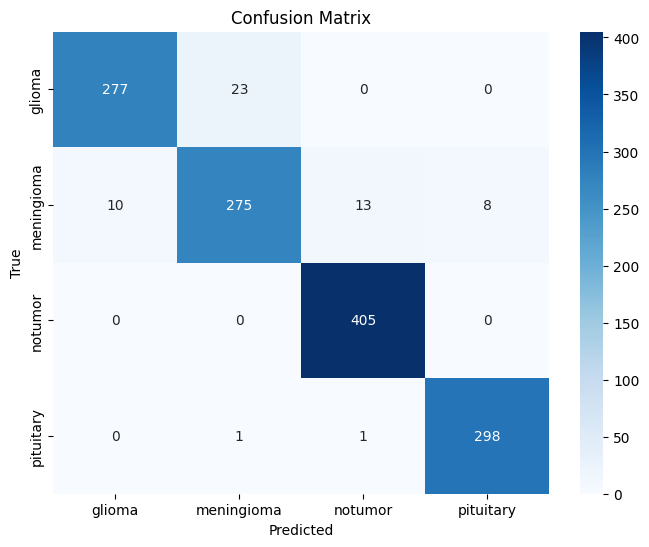


Classification Report:

              precision    recall  f1-score   support

      glioma       0.97      0.92      0.94       300
  meningioma       0.92      0.90      0.91       306
     notumor       0.97      1.00      0.98       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.96      0.96      1311



In [5]:
from plot_utils import (
    plot_training_curves,
    evaluate_model_with_confusion,
    plot_confusion_matrix_from_dataset
)
# Load datasets with batch size 16 (or whatever you used during training)
train_ds, val_ds, test_ds = load_datasets(batch_size=16)

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Confusion matrix with in-memory model
# evaluate_model_with_confusion(model19, test_ds, title="Confusion Matrix (Test)")

# Confusion matrix from saved model
plot_confusion_matrix_from_dataset("models/model11_best.h5", test_ds, class_names)
